## XGBoost (Extreme Gradient Boosting)
#### Особенности:
* Более регуляризованный бустинг (L1 и L2-регуляризация)
* Обработка пропусков
* Параллельная обработка деревьев
* Алгоритм "approximate greedy" с использованием гистограмм

В отличие от GBM в XGboost изначальный прогноз регрессионного дерева устанавливается f_0 (x) = 0.5 и вместо пней с глубиной 3 берутся более глубокие деревья с листьями в диапазоне от 8 до 32 как в случае регрессии, так и классификации, а к функции потерь добавляется регуляризация (L1 или L2 на выбор), которая штрафует дерево с высокой суммой нормы значений в листьях. Данная сумма представлена в виде целевой функции, расчёт значений которой аппроксимируется разложением в ряд Тейлора 2-го порядка

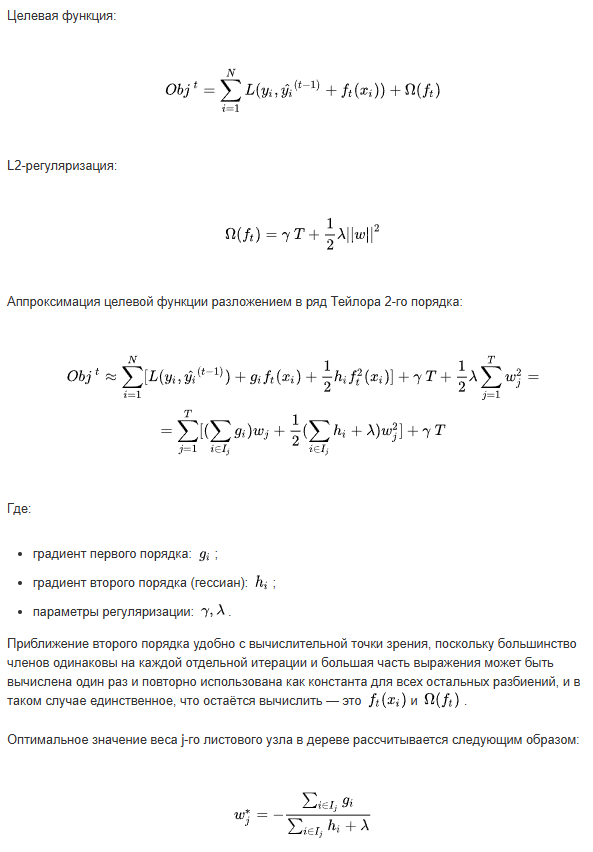

In [1]:
from IPython.display import Image
Image('form1.png')

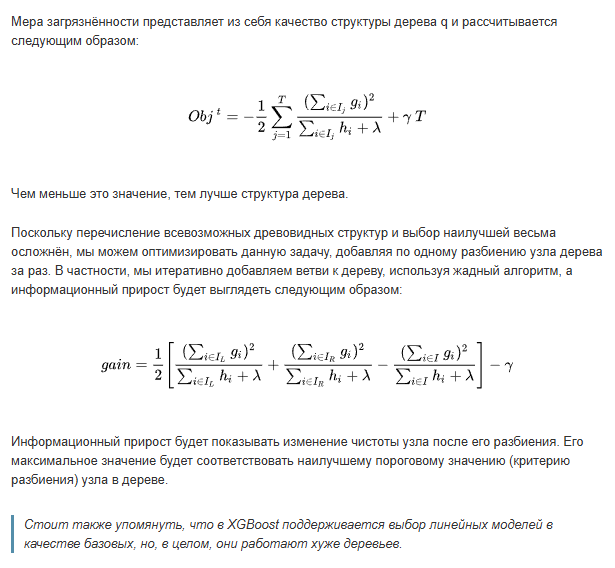

In [2]:
Image('form2.png')

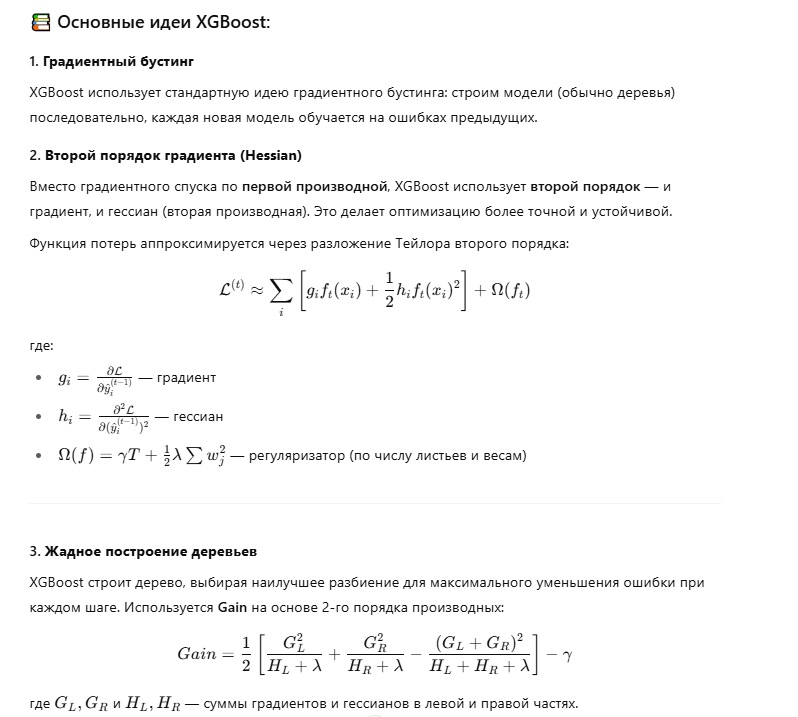

In [3]:
Image('idea1.png')

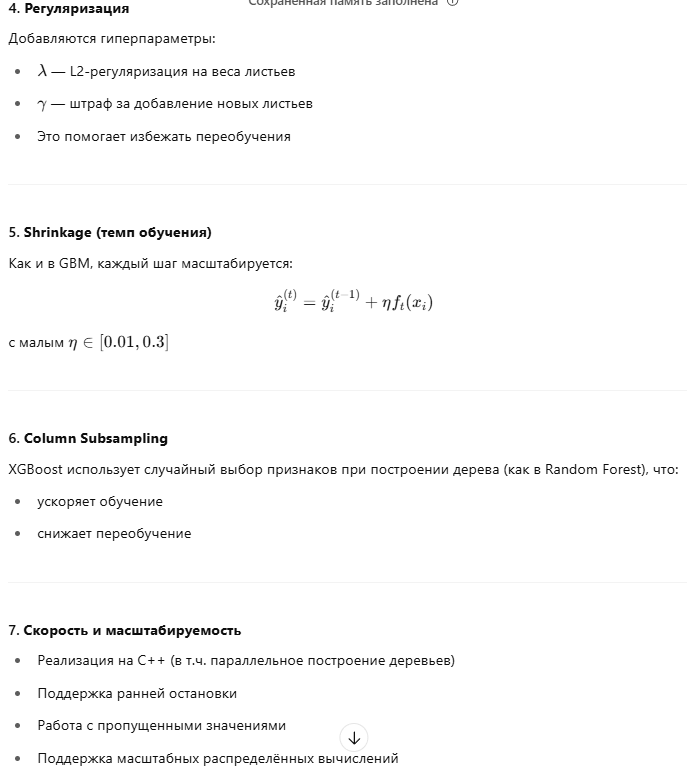

In [4]:
Image('idea2.png')

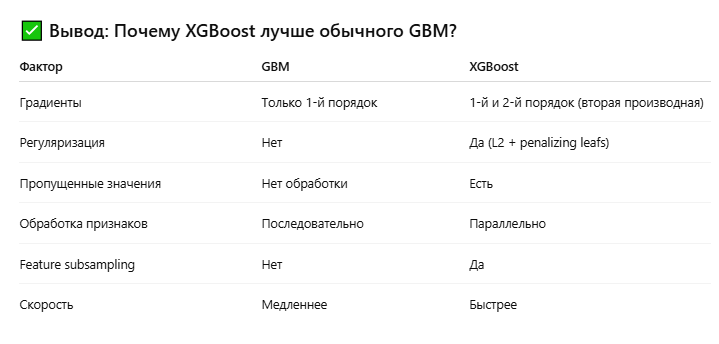

In [5]:
Image('conc.png')

# Реализация XGBRegressor (упрощённая, без регуляризации)

In [6]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

In [7]:
class XGBRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def _gradient(self, y_true, y_pred):
        # Первая производная (градиент)
        return y_pred - y_true

    def _hessian(self, y_true, y_pred):
        # Вторая производная (гессиан)
        return np.ones_like(y_true)

    def fit(self, X, y):
        self.trees = []
        y_pred = np.zeros_like(y, dtype=float)

        for i in range(self.n_estimators):
            g = self._gradient(y, y_pred)
            h = self._hessian(y, y_pred)

            # Взвешенные значения для обучения
            target = -g / h

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, target)
            update = tree.predict(X)

            y_pred += self.learning_rate * update
            self.trees.append(tree)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


# Добавим

In [8]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class XGBRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1.0, gamma=0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.trees = []
        self.weights = []

    def _gradient(self, y_true, y_pred):
        return y_pred - y_true

    def _hessian(self, y_true, y_pred):
        return np.ones_like(y_true)

    def fit(self, X, y):
        self.trees = []
        self.weights = []
        y_pred = np.zeros_like(y, dtype=float)

        for _ in range(self.n_estimators):
            g = self._gradient(y, y_pred)
            h = self._hessian(y, y_pred)

            # Взвешенное целевое значение
            pseudo_residual = -g

            # Обучаем дерево на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, pseudo_residual)

            # Получим индексы листьев
            leaf_indices = tree.apply(X)
            unique_leaves = np.unique(leaf_indices)

            # Вычисляем оптимальные значения весов для каждого листа
            leaf_weights = {}
            for leaf in unique_leaves:
                idx = (leaf_indices == leaf)
                G = np.sum(g[idx])
                H = np.sum(h[idx])
                if H + self.reg_lambda == 0:
                    w = 0
                else:
                    w = -G / (H + self.reg_lambda)
                # Применяем минимальное улучшение (gamma)
                if 0.5 * G**2 / (H + self.reg_lambda) < self.gamma:
                    w = 0
                leaf_weights[leaf] = w

            # Обновление предсказания
            update = np.array([leaf_weights[leaf] for leaf in leaf_indices])
            y_pred += self.learning_rate * update

            self.trees.append(tree)
            self.weights.append(leaf_weights)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree, leaf_weights in zip(self.trees, self.weights):
            leaf_indices = tree.apply(X)
            update = np.array([leaf_weights.get(leaf, 0) for leaf in leaf_indices])
            y_pred += self.learning_rate * update
        return y_pred


Сравню с склерн

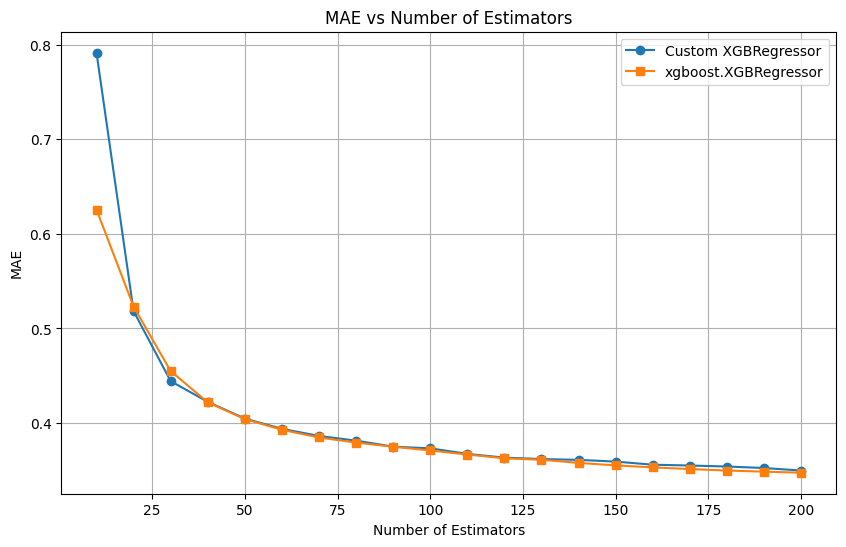

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor as XGBOfficial

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

custom_mae = []
official_mae = []
n_estimators_list = list(range(10, 201, 10))  # от 10 до 200 деревьев

for n in n_estimators_list:
    # Моя реализация
    model_custom = XGBRegressor(n_estimators=n, learning_rate=0.1, max_depth=3)
    model_custom.fit(X_train, y_train)
    y_pred_custom = model_custom.predict(X_test)
    custom_mae.append(mean_absolute_error(y_test, y_pred_custom))

    # Официальная реализация XGBoost
    model_official = XGBOfficial(n_estimators=n, learning_rate=0.1, max_depth=3, objective='reg:squarederror')
    model_official.fit(X_train, y_train)
    y_pred_official = model_official.predict(X_test)
    official_mae.append(mean_absolute_error(y_test, y_pred_official))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, custom_mae, label='Custom XGBRegressor', marker='o')
plt.plot(n_estimators_list, official_mae, label='xgboost.XGBRegressor', marker='s')
plt.xlabel('Number of Estimators')
plt.ylabel('MAE')
plt.title('MAE vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()


# Теперь классификация

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class XGBClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.base_score = 0

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        # Инициализация логитов через логарифм шансов
        pos_ratio = np.clip(np.mean(y), 1e-5, 1 - 1e-5)  # чтобы избежать деления на 0
        self.base_score = np.log(pos_ratio / (1 - pos_ratio))
        pred = np.full(len(y), self.base_score)

        for _ in range(self.n_estimators):
            prob = self._sigmoid(pred)
            grad = prob - y                         # ∂L/∂f (градиент)
            hess = prob * (1 - prob)                # ∂²L/∂f² (гессиан)

            # Newton step: g/h (бинарный логлосс -> использует 2-й порядок)
            update_target = -grad / (hess + 1e-6)

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, update_target, sample_weight=hess)
            update = tree.predict(X)

            pred += self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.base_score)
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        proba = self._sigmoid(pred)
        return np.vstack([1 - proba, proba]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.958041958041958


G:\Python 3.11\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
G:\Python 3.11\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
G:\Python 3.11\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
G:\Python 3.11\Python\

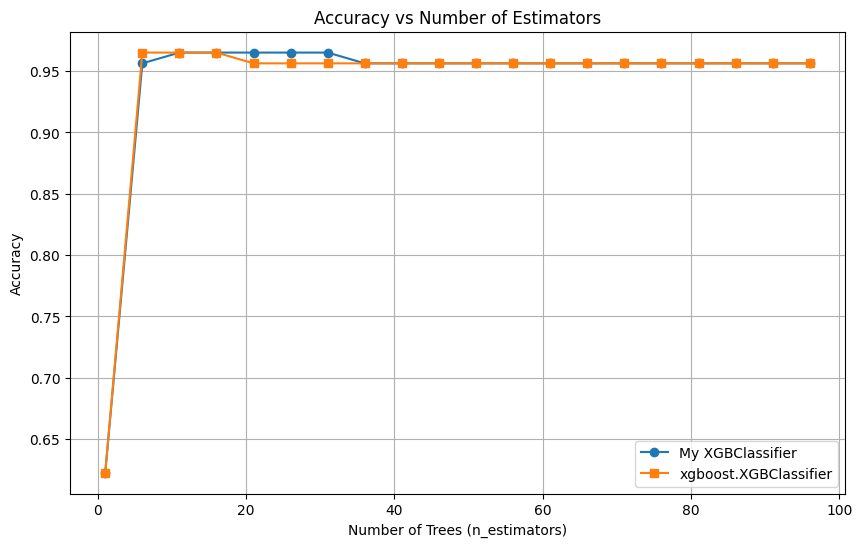

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier as XGBLibClassifier

# 1. Датасет
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Подготовка метрик
n_estimators_list = list(range(1, 101, 5))
my_accs = []
xgb_accs = []

for n in n_estimators_list:
    # Моя реализация
    my_model = XGBClassifier(n_estimators=n, learning_rate=0.1, max_depth=3)
    my_model.fit(X_train, y_train)
    preds = my_model.predict(X_test)
    my_accs.append(accuracy_score(y_test, preds))

    # Библиотечная реализация
    xgb_model = XGBLibClassifier(n_estimators=n, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    preds_xgb = xgb_model.predict(X_test)
    xgb_accs.append(accuracy_score(y_test, preds_xgb))

# 3. Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, my_accs, label="My XGBClassifier", marker='o')
plt.plot(n_estimators_list, xgb_accs, label="xgboost.XGBClassifier", marker='s')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()


# Дополнительные оптимизации в XGBoost
### Weighted quantile sketch
В случае работы с большими наборами данных в XGBoost используется приближённый жадный алгоритм. Это означает, что вместо тестирования всех возможных пороговых значений мы тестируем только квантили. Используя распараллеливание для разделения набора данных и создания ветвей в каждом дереве независимо друг от друга чтобы несколько ядер могли работать с ними одновременно, алгоритм взвешенных квантилей (weighted quantile sketch) объединяет данные в приближённую гистограмму, разделённую на взвешенные квантили, которые помещают наблюдения с прогнозами низкой достоверности в квантили с меньшим количеством наблюдений.

### Cache-aware access & out-of-core computing
Для более быстрого вычисления прогнозов градиенты и гессианы хранятся в кэш-памяти (cache-aware access), а в случае с датасетами большого размера, когда недостаточно кэш и оперативной памяти, задействуется память из жёсткого диска. Учитывая, что чтение данных на жёстком диске выполняется гораздо медленнее чем в кэш-памяти, для ускоренной обработки производится их компрессия. Данные хранятся в единицах памяти, называемых блоками, информация в которых хранится в формате сжатых столбцов, отсортированных по соответствующим значениям параллельно с использованием всех доступных ядер ЦП, а распаковка каждого блока осуществляется в независимом потоке при загрузке в память. Данная техника называется "вычисление вне ядра" (out-of-core computing). При наличии нескольких жёстких дисков, применяется параллельное сегментирование блоков для каждого жёсткого диска (sharding).

При использовании сжатых данных необходимо учитывать, что процесс сжатия и распаковки занимает дополнительное время, поэтому выбор алгоритма сжатия (с потерями и без) и его параметров может повлиять на производительность в целом, однако это всё равно значительно быстрее чтения без сжатия.

### Sparsity-aware split finding
В XGboost также поддерживается работа с пропусками. Суть заключается в следующем: из исходного датасета убираются наблюдения с пропусками и представляются как отдельный датасет. После построения дерева для наблюдений без пропусков рассчитываются их остатки, далее — остатки для наблюдений с пропусками, которые присоединяются к остаткам дерева как для левого, так и для правого узла. В конце рассчитывается информационный прирост (gain) для каждого узла в дереве: выбирается порог для разбиения с максимальным приростом. Данная техника называется "поиск разбиения с учётом разряженности" (sparsity-aware split finding).

### Обучение на GPU
Для ускорения процесса обучения в XGBoost реализована поддержка GPU с помощью параметров device="cuda" и tree_method="gpu_hist". Также стоит отметить, что в данном алгоритме поддерживается полностью распределённое обучение на GPU с использованием Dask, Spark и PySpark.

# Преимущества и недостатки XGBoost
### Преимущества:
* относительно высокая скорость обучения и точность прогнозов;
* возможность работы с пропусками;
* гибкость в конфигурации из-за большого количества гиперпараметров.
### Недостатки:
* сложность в конфигурации из-за большого количества гиперпараметров;
* на данный момент отсутствует полноценная (присутствует экспериментальная) возможность работы с категориальными признаками, что может сильно снизить производительность при кодировании больших объёмов данных.